In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import numpy as np
import matplotlib.pyplot as plt
import csv
from tifffile import imread
import matplotlib.gridspec as gridspec
import cv2
import os
import glob
from sklearn.cluster import KMeans
from matplotlib.colors import LinearSegmentedColormap
import peakutils
from skimage import exposure
# import pandas as pd
from sklearn.cluster import KMeans
import sklearn.preprocessing
import sklearn.decomposition #for PCA

pca = sklearn.decomposition.PCA(n_components=2)

perform_PCA = False

In [ ]:
#Elbow plot for n clusters

from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,18)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(total_temporal_traces)
    kmeanModel.fit(total_temporal_traces)
    distortions.append(sum(np.min(cdist(total_temporal_traces, kmeanModel.cluster_centers_, 'euclidean'), axis=1))) / total_temporal_traces.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# Left for posterity's sake, will delete in 1-2 versions
# def get_clustered_dict(labelled_clusters, ):
#     #Creates a dictionary with clusters as keys and values as kept ROI number
#     grouped_KMeans_dict = {}
#     for label, roi_num in zip(labelled_clusters, kept_rois):
#         if label not in grouped_KMeans_dict:
#             roi_list = [roi_num]
#             grouped_KMeans_dict[label] = roi_list
#         else:
#             roi_list = [roi_num]
#             grouped_KMeans_dict[label] = grouped_KMeans_dict[label] + roi_list


In [3]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    
    #consider qualitative colormap for clustered colours such as 'Set1'
    return plt.cm.get_cmap(name, n)

def adjust_contrast(image, contrast):
    return image*contrast

def adjust_gamma(image, gamma):
    return exposure.adjust_gamma(image, gamma)

# Optionally apply gamma and contrast adjustment
gamma    = 1.1
contrast = 1.5

# Define a colormap for ROIs
n_colors = 20
cmap = get_cmap(n_colors)

def blend_transparent(face_img, overlay_t_img):
    # Split out the transparency mask from the colour info
    overlay_img = overlay_t_img[:,:,:3] # Grab the BRG planes
    overlay_mask = overlay_t_img[:,:,3:]  # And the alpha plane

    # Again calculate the inverse mask
    background_mask = 255 - overlay_mask

    # Turn the masks into three channel, so we can use them as weights
    overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
    background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)

    # Create a masked out face image, and masked out overlay
    # We convert the images to floating point in range 0.0 - 1.0
    face_part = (face_img * (1 / 255.0)) * (background_mask * (1 / 255.0))
    overlay_part = (overlay_img * (1 / 255.0)) * (overlay_mask * (1 / 255.0))

    # And finally just add them together, and rescale it back to an 8bit integer image    
    return np.uint8(cv2.addWeighted(face_part, 255.0, overlay_part, 255.0, 0.0))

In [4]:
def get_total_sorted_rois(video, temporal_footprints, removed_rois, n_clusters):
    '''Sorts the ROIS by temporal trace by plane, concatenates them in a list, performs K-Means clustering on all of the kept ROIs
    concatenated list and a list of total sorted ROIs labelled by cluster is returned.'''    
    total_sorted_temporal_traces = []
    total_sorted_kept_rois = []
    temp_footprints = temporal_footprints[:]

    for z in range(video.shape[1]):                
        kept_rois = [ i for i in range(temporal_footprints[z].shape[0]) if i not in removed_rois[z] ]
        
        zscoreNum = temporal_footprints[z][kept_rois] - np.mean(temporal_footprints[z][kept_rois], axis=1)[:, np.newaxis]
        zscorePreDen = np.std(temporal_footprints[z][kept_rois], axis=1)[:, np.newaxis]
        preDenBoolArr = np.isnan(zscorePreDen)
        mmzscoreDen = np.where(zscorePreDen != 0, zscorePreDen, 1)# replaces 0 with 1 so the denominator isn't 0
        zscore = zscoreNum / mmzscoreDen
        
        # Compute sorted data based on correlations of z-scored data
        correlations = np.corrcoef(zscore)
        i, j = np.unravel_index(correlations.argmin(), correlations.shape)

        temp_footprints[z] = temporal_footprints[z][kept_rois]
        temp_footprints[z][0] = zscore[i]
        total_sorted_temporal_traces.append(zscore[i])
        temp_footprints[z][-1] = zscore[j]
        
        sorted_kept_rois = kept_rois[:]
        
        sorted_kept_rois[0] = kept_rois[i]
        sorted_kept_rois[-1] = kept_rois[j]

        remaining_indices = [ index for index in range(temp_footprints[z].shape[0]) if index not in (i, j) ]
            
        for k in range(1, temp_footprints[z].shape[0]-1):
            corrs_1 = [ correlations[i, index] for index in remaining_indices ]
            corrs_2 = [ correlations[j, index] for index in remaining_indices ]

            difference = [ corrs_1[l] - corrs_2[l] for l in range(len(remaining_indices)) ]
            l = np.argmax(difference)
            index = remaining_indices[l]

            temp_footprints[z][k] = zscore[index]
            
            sorted_kept_rois[k] = kept_rois[index]
            
            total_sorted_temporal_traces.append(temp_footprints[z][k])
            
            del remaining_indices[l]
        total_sorted_temporal_traces.append(zscore[j])
        for roi in sorted_kept_rois:
            total_sorted_kept_rois.append(str(z)+'z'+str(roi))
            
#     n_clusters = n_clusters
    kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters) # n=3 is arbitrary, will perform other calculations to figure it out
    clustered_data = kmeans.fit(total_sorted_temporal_traces)

    labelled_total_list = kmeans.labels_
    
    grouped_KMeans_dict = {}
    for label, roi_num in zip(labelled_total_list, total_sorted_kept_rois):
        if label not in grouped_KMeans_dict:
            roi_list = [roi_num]
            grouped_KMeans_dict[label] = roi_list
        else:
            roi_list = [roi_num]
            grouped_KMeans_dict[label] = grouped_KMeans_dict[label] + roi_list
    
    return labelled_total_list, grouped_KMeans_dict, total_sorted_temporal_traces


In [5]:
def create_plot(video_path, roi_path, tail_path, **kwargs):
    save_dir = kwargs.get('save_dir', './')
    
    # Load all data
    rois        = np.load(roi_path, allow_pickle=True)
    video       = imread(video_path)
    
    prefix = os.path.basename(video_path)[:-4]
    
    temporal_footprints   = rois[()]['roi_temporal_footprints']
    temp_residuals        = rois[()]['roi_temporal_residuals']
    spatial_footprints    = rois[()]['roi_spatial_footprints']
    bg_temp_footprints    = rois[()]['bg_temporal_footprints']
    bg_spatial_footprints = rois[()]['bg_spatial_footprints']
    removed_rois          = rois[()]['all_removed_rois']
    
    n_clusters = 3
    labelled_total_list, grouped_KMeans_dict, total_sorted_temporal_traces = get_total_sorted_rois(video, temporal_footprints, removed_rois, n_clusters)
    label_counter = 0
    
    
    # Create the figure
    fig = plt.figure(figsize=(30, 25), dpi=200)
        
    # Create gridspecs
#     gs0 = gridspec.GridSpec(1, 4, width_ratios=[1, 2, 2, 1])
#     gs1 = gridspec.GridSpecFromSubplotSpec(int(video.shape[1]/2)*3+2, 2, width_ratios=[0.9, 0.05], height_ratios=[1, 0.1]+[0.1, 0.8, 0.1]*int(video.shape[1]/2), subplot_spec=gs0[0])
# #     gs2 = gridspec.GridSpecFromSubplotSpec(int(video.shape[1]/2)*3+2, 2, width_ratios=[0.1, 1.9], height_ratios=[1, 0.1]+[0.1, 0.8, 0.1]*int(video.shape[1]/2), subplot_spec=gs0[1], wspace=0)
# #     gs3 = gridspec.GridSpecFromSubplotSpec(int(video.shape[1]/2)*3+2, 2, width_ratios=[0.1, 1.9], height_ratios=[1, 0.1]+[0.1, 0.8, 0.1]*int(video.shape[1]/2), subplot_spec=gs0[2], wspace=0)
#     gs4 = gridspec.GridSpecFromSubplotSpec(int(video.shape[1]/2)*3+2, 2, width_ratios=[0.05, 0.9], height_ratios=[1, 0.1]+[0.1, 0.8, 0.1]*int(video.shape[1]/2), subplot_spec=gs0[3])
    gs0 = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 1])
    gs1 = gridspec.GridSpecFromSubplotSpec(int(video.shape[1]/2)*3+2, 2, subplot_spec=gs0[0], wspace=0.025)
    gs4 = gridspec.GridSpecFromSubplotSpec(int(video.shape[1]/2)*3+2, 2, subplot_spec=gs0[2], wspace=0.025)

 
    
#     gs1 = gridspec.GridSpecFromSubplotSpec(int(video.shape[1]/2)*3+2, 2, width_ratios=[0.9, 0.05], height_ratios=[1, 0.1]+[0.1, 0.8, 0.1]*int(video.shape[1]/2), subplot_spec=gs0[1])
#     gs4 = gridspec.GridSpecFromSubplotSpec(int(video.shape[1]/2)*3+2, 2, width_ratios=[0.05, 0.9], height_ratios=[1, 0.1]+[0.1, 0.8, 0.1]*int(video.shape[1]/2), subplot_spec=gs0[2])

    # Copy the temporal footprints list
    temp_footprints = temporal_footprints[:]
    
    for z in range(video.shape[1]):                
        all_colors = [ (np.random.uniform(50, 200), np.random.uniform(50, 200), np.random.uniform(50, 200)) for i in range(10000) ]
        kept_rois = [ i for i in range(temporal_footprints[z].shape[0]) if i not in removed_rois[z] ]
        
        zscoreNum = temporal_footprints[z][kept_rois] - np.mean(temporal_footprints[z][kept_rois], axis=1)[:, np.newaxis]
        zscorePreDen = np.std(temporal_footprints[z][kept_rois], axis=1)[:, np.newaxis]
        preDenBoolArr = np.isnan(zscorePreDen)
        mmzscoreDen = np.where(zscorePreDen != 0, zscorePreDen, 1)
        zscore = zscoreNum / mmzscoreDen
        
        # Compute sorted data based on correlations of z-scored data
        correlations = np.corrcoef(zscore)
        i, j = np.unravel_index(correlations.argmin(), correlations.shape)

        temp_footprints[z] = temporal_footprints[z][kept_rois]
        temp_footprints[z][0] = zscore[i]
        temp_footprints[z][-1] = zscore[j]
        
        sorted_kept_rois = kept_rois[:]
        
        sorted_kept_rois[0] = kept_rois[i]
        sorted_kept_rois[-1] = kept_rois[j]

        remaining_indices = [ index for index in range(temp_footprints[z].shape[0]) if index not in (i, j) ]
            
        for k in range(1, temp_footprints[z].shape[0]-1):
            corrs_1 = [ correlations[i, index] for index in remaining_indices ]
            corrs_2 = [ correlations[j, index] for index in remaining_indices ]

            difference = [ corrs_1[l] - corrs_2[l] for l in range(len(remaining_indices)) ]
            l = np.argmax(difference)
            index = remaining_indices[l]

            temp_footprints[z][k] = zscore[index]
            
            sorted_kept_rois[k] = kept_rois[index]
            
            del remaining_indices[l]
        
        # Create the background image (mean of the video)
        video_max = np.amax(video)
        image = np.mean(video[:, z, :, :], axis=0)
        image = adjust_gamma(adjust_contrast(image, contrast), gamma)
        image = 255.0*image/video_max
        image[image > 255] = 255
        image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_GRAY2RGB)
        
        kept_footprints = temp_footprints[z]
        
#         plt.imshow(image)
        
    # Create the ROI overlays
        roi_spatial_footprints = spatial_footprints[z].toarray().reshape((video.shape[2], video.shape[3], spatial_footprints[z].shape[-1])).transpose((0, 1, 2))
        overlays = np.zeros((roi_spatial_footprints.shape[-1], image.shape[0], image.shape[1], 4)).astype(np.uint8)
        total_mask = np.zeros((image.shape[0], image.shape[1]))
        
        roi_contours = []

        for j in range(len(kept_rois)):
            i = kept_rois[j]
            sorted_roi_index = (len(kept_rois) - j) - 1
            maximum = np.amax(roi_spatial_footprints[:, :, i])
            mask = (roi_spatial_footprints[:, :, i] > 0).copy()

            contours = cv2.findContours(mask.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2]

            contour = max(contours, key=cv2.contourArea)
            
            roi_contours.append(contour)

            M = cv2.moments(contour)
            if M["m00"] != 0:
                center_x = int(M["m10"] / M["m00"])
                center_y = int(M["m01"] / M["m00"])
            else:
                center_x = 0
                center_y = 0
                
            color = cmap(sorted_roi_index % n_colors)[:3]
            if labelled_total_list[label_counter] == 0:
                color = [255, 0, 0]
            elif labelled_total_list[label_counter] == 1:
                color = [0, 255, 0]
            elif labelled_total_list[label_counter] == 3:
                color = [255, 217, 0] #Yellow is R255 G217 B0
            else:
                color = [0, 0, 255]
            overlay = np.zeros((image.shape[0], image.shape[1], 4)).astype(np.uint8)

            overlay[mask, :-1] = color
            overlay[mask, -1] = 205.0*roi_spatial_footprints[mask, i]/maximum + 50
            overlays[i] = overlay
            
            total_mask += mask
            label_counter += 1
        
        # Create the final ROI image (blending the mean image and the overlays)
        denominator = np.count_nonzero(overlays[kept_rois], axis=0)
        denominator[denominator == 0] = 1
        roi_overlay = (np.sum(overlays[kept_rois], axis=0)/denominator).astype(np.uint8)
        
        image = blend_transparent(image, roi_overlay)
        
        # -- ROI SPATIAL FOOTPRINTS PLOT -- #
        if z < video.shape[1]/2:
            ax = plt.subplot(gs1[z*3+2:z*3+5, 0:2])
        else:
            ax = plt.subplot(gs4[(z-5)*3+2:(z-5)*3+5, 0:2])
        fig.add_subplot(ax)
        
        plt.imshow(image)
        
        # Add text label for each ROI
        for j in range(len(kept_rois)):
            i = kept_rois[j]
            
            sorted_roi_index = (len(kept_rois) - j) - 1
            mmvar = str(i) + ', ' + str(sorted_roi_index)
            x = np.amax(roi_contours[j][:, 0, 0])
            y = np.amax(roi_contours[j][:, 0, 1])
            
            color = 'white'#cmap(sorted_roi_index % n_colors)[:3]
            
            plt.text(x, y, sorted_roi_index, color=color, size=5)
            
        plt.axis('off')        
    
    # Save the plot
    plt.savefig(save_dir + "meanIMG.png")
    

In [6]:
main_path  = 'E:/Analysis/Jordan/PAG/Oct.30.19_3C/Oct.30.19_huc6f_7dpf_fish3_PAG_loom_lv30_3C-1_mc/'
video_path = main_path+"Oct.30.19_huc6f_7dpf_fish3_PAG_loom_lv30_3C-1_mc.tif"
roi_path   = main_path+"roi_data.npy"
tail_path  = main_path+"Feb.25.20_1C_tail_angles1.csv"
# Mar.5.20_HUC6f_8dpf_loom_lv30_1B-1_mc.tif
rois = np.load(roi_path, allow_pickle=True)
video = imread(video_path)

# the important part - run the function to create the plot
create_plot(video_path, roi_path, tail_path, save_dir=main_path)

SyntaxError: EOL while scanning string literal (<ipython-input-6-c905f653e9de>, line 1)

In [21]:
# cell for standalone functions

main_path  = 'E:/Analysis/Jordan/PAG/Oct.30.19_3C/Oct.30.19_huc6f_7dpf_fish3_PAG_loom_lv30_3C-1_mc/'
video_name = "Oct.30.19_huc6f_7dpf_fish3_PAG_loom_lv30_3C-1_mc.tif"
video_path = main_path+video_name
roi_path   = main_path+"roi_data.npy"
tail_path  = main_path+"Feb.25.20_1C_tail_angles1.csv"

def get_data(video_path, roi_path, tail_path, **kwargs):
    '''Loads data to variables to allow individual functions to be called. Allows for the visualization and inspection of
    subsets of the data. Returns temporal/spatial footprints, kept rois, labels. '''
    
    # Load all data
    rois        = np.load(roi_path, allow_pickle=True)
    video       = imread(video_path)
    
    prefix = os.path.basename(video_path)[:-4]
    
    temporal_footprints   = rois[()]['roi_temporal_footprints']
    temp_residuals        = rois[()]['roi_temporal_residuals']
    spatial_footprints    = rois[()]['roi_spatial_footprints']
    bg_temp_footprints    = rois[()]['bg_temporal_footprints']
    bg_spatial_footprints = rois[()]['bg_spatial_footprints']
    removed_rois          = rois[()]['all_removed_rois']
    
    n_clusters = 3
    labelled_total_list, grouped_KMeans_dict, total_sorted_temporal_traces = get_total_sorted_rois(video, temporal_footprints, removed_rois, n_clusters)
    return labelled_total_list, total_sorted_temporal_traces, grouped_KMeans_dict

def show_clusters(video, temporal_footprints):
    '''A stand-alone function to show how the ROIs get clustered.'''
    total_temporal_traces = []
    total_kept_rois = []
    n_clusters = 3
    for z in range(video.shape[1]):
        # Make a list of ROIs to plot (just the kept ROIs)
        kept_rois = [ i for i in range(temporal_footprints[z].shape[0]) if i not in removed_rois[z] ]

        zscoreNum = temporal_footprints[z][kept_rois] - np.mean(temporal_footprints[z][kept_rois], axis=1)[:, np.newaxis]
        zscorePreDen = np.std(temporal_footprints[z][kept_rois], axis=1)[:, np.newaxis]
        preDenBoolArr = np.isnan(zscorePreDen)
        mmzscoreDen = np.where(zscorePreDen != 0, zscorePreDen, 1)
        zscore = zscoreNum / mmzscoreDen

        for trace in zscore:
            total_temporal_traces.append(trace)
        for roi in kept_rois:
            total_kept_rois.append((str(z) + 'z'+ str(roi)))    

    
    kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters) # n=3 is arbitrary, will perform other calculations to figure it out
    if perform_PCA == True:
        clustered_data = kmeans.fit(principal_components)
    else:
        clustered_data = kmeans.fit(total_temporal_traces)

    #prints the clusters as well as the kept ROIs
    labelled_clusters = kmeans.labels_
    print('The ROIs are clustered as follows: ' + str(labelled_clusters))
    # print('The kept ROIs are: ' + str(total_kept_rois))
    print(len(labelled_clusters))

In [8]:
# total_temporal_traces
# labelled_total_list 
labelled_total_list, total_sorted_temporal_traces, KMeans_dict = get_data(video_path, roi_path, tail_path)
label3 = []
label2 = []
label1 = []
label0 = []
for label, trace in zip(labelled_total_list, total_sorted_temporal_traces):
    if label == 2:
        label2.append(trace)
    elif label == 1:
        label1.append(trace)
    elif label == 3:
        label3.append(trace)
    else:
        label0.append(trace)

label0_prop = int(10*(len(label0)/len(labelled_total_list)))
label1_prop = int(10*(len(label1)/len(labelled_total_list)))
label2_prop = int(10*(len(label2)/len(labelled_total_list)))
label3_prop = int(10*(len(label3)/len(labelled_total_list)))
print("The labels are label 0, 1, 2, 3 in order ", label0_prop, label1_prop, label2_prop, label3_prop)

The labels are label 0, 1, 2, 3 in order  3 3 2 0


In [9]:
print("The labels are label 0, 1, 2, 3 in order ", label0_prop, label1_prop, label2_prop, label3_prop)

The labels are label 0, 1, 2, 3 in order  3 3 2 0


In [10]:
print(len(label0))
print(len(label1))
print(len(label2))
print(len(label3))

87
95
69
0


In [11]:
color0 = []
color1 = []
color2 = []
blue = 0
color_dict = {}
for i in KMeans_dict:
    label_num = str(i)
    for j in KMeans_dict[i]:
#         print(j[0:2])
        if j[:2] == '0z' or j[:2] == '1z' or j[:2] == '2z':
            if i == 0:
                color0.append('red')
            elif i == 1:
                color1.append('red')
            else:
                color2.append('red')
        elif j[:2] == '3z' or j[:2] == '4z' or j[:2] == '5z' or j[:2] == '6z':
            if i == 0:
                color0.append('blue')
            elif i == 1:
                color1.append('blue')
            else:
                color2.append('blue')
        else:
            if i == 0:
                color0.append('green')
            elif i == 1:
                color1.append('green')
            else:
                color2.append('green')


In [12]:
print('colour lengths are: ')
print(len(color0))
print(len(color1))
print(len(color2))

print('dict lengths are: ')
print(len(KMeans_dict[0]))
print(len(KMeans_dict[1]))
print(len(KMeans_dict[2]))

print(KMeans_dict)

87
95
69
87
95
69


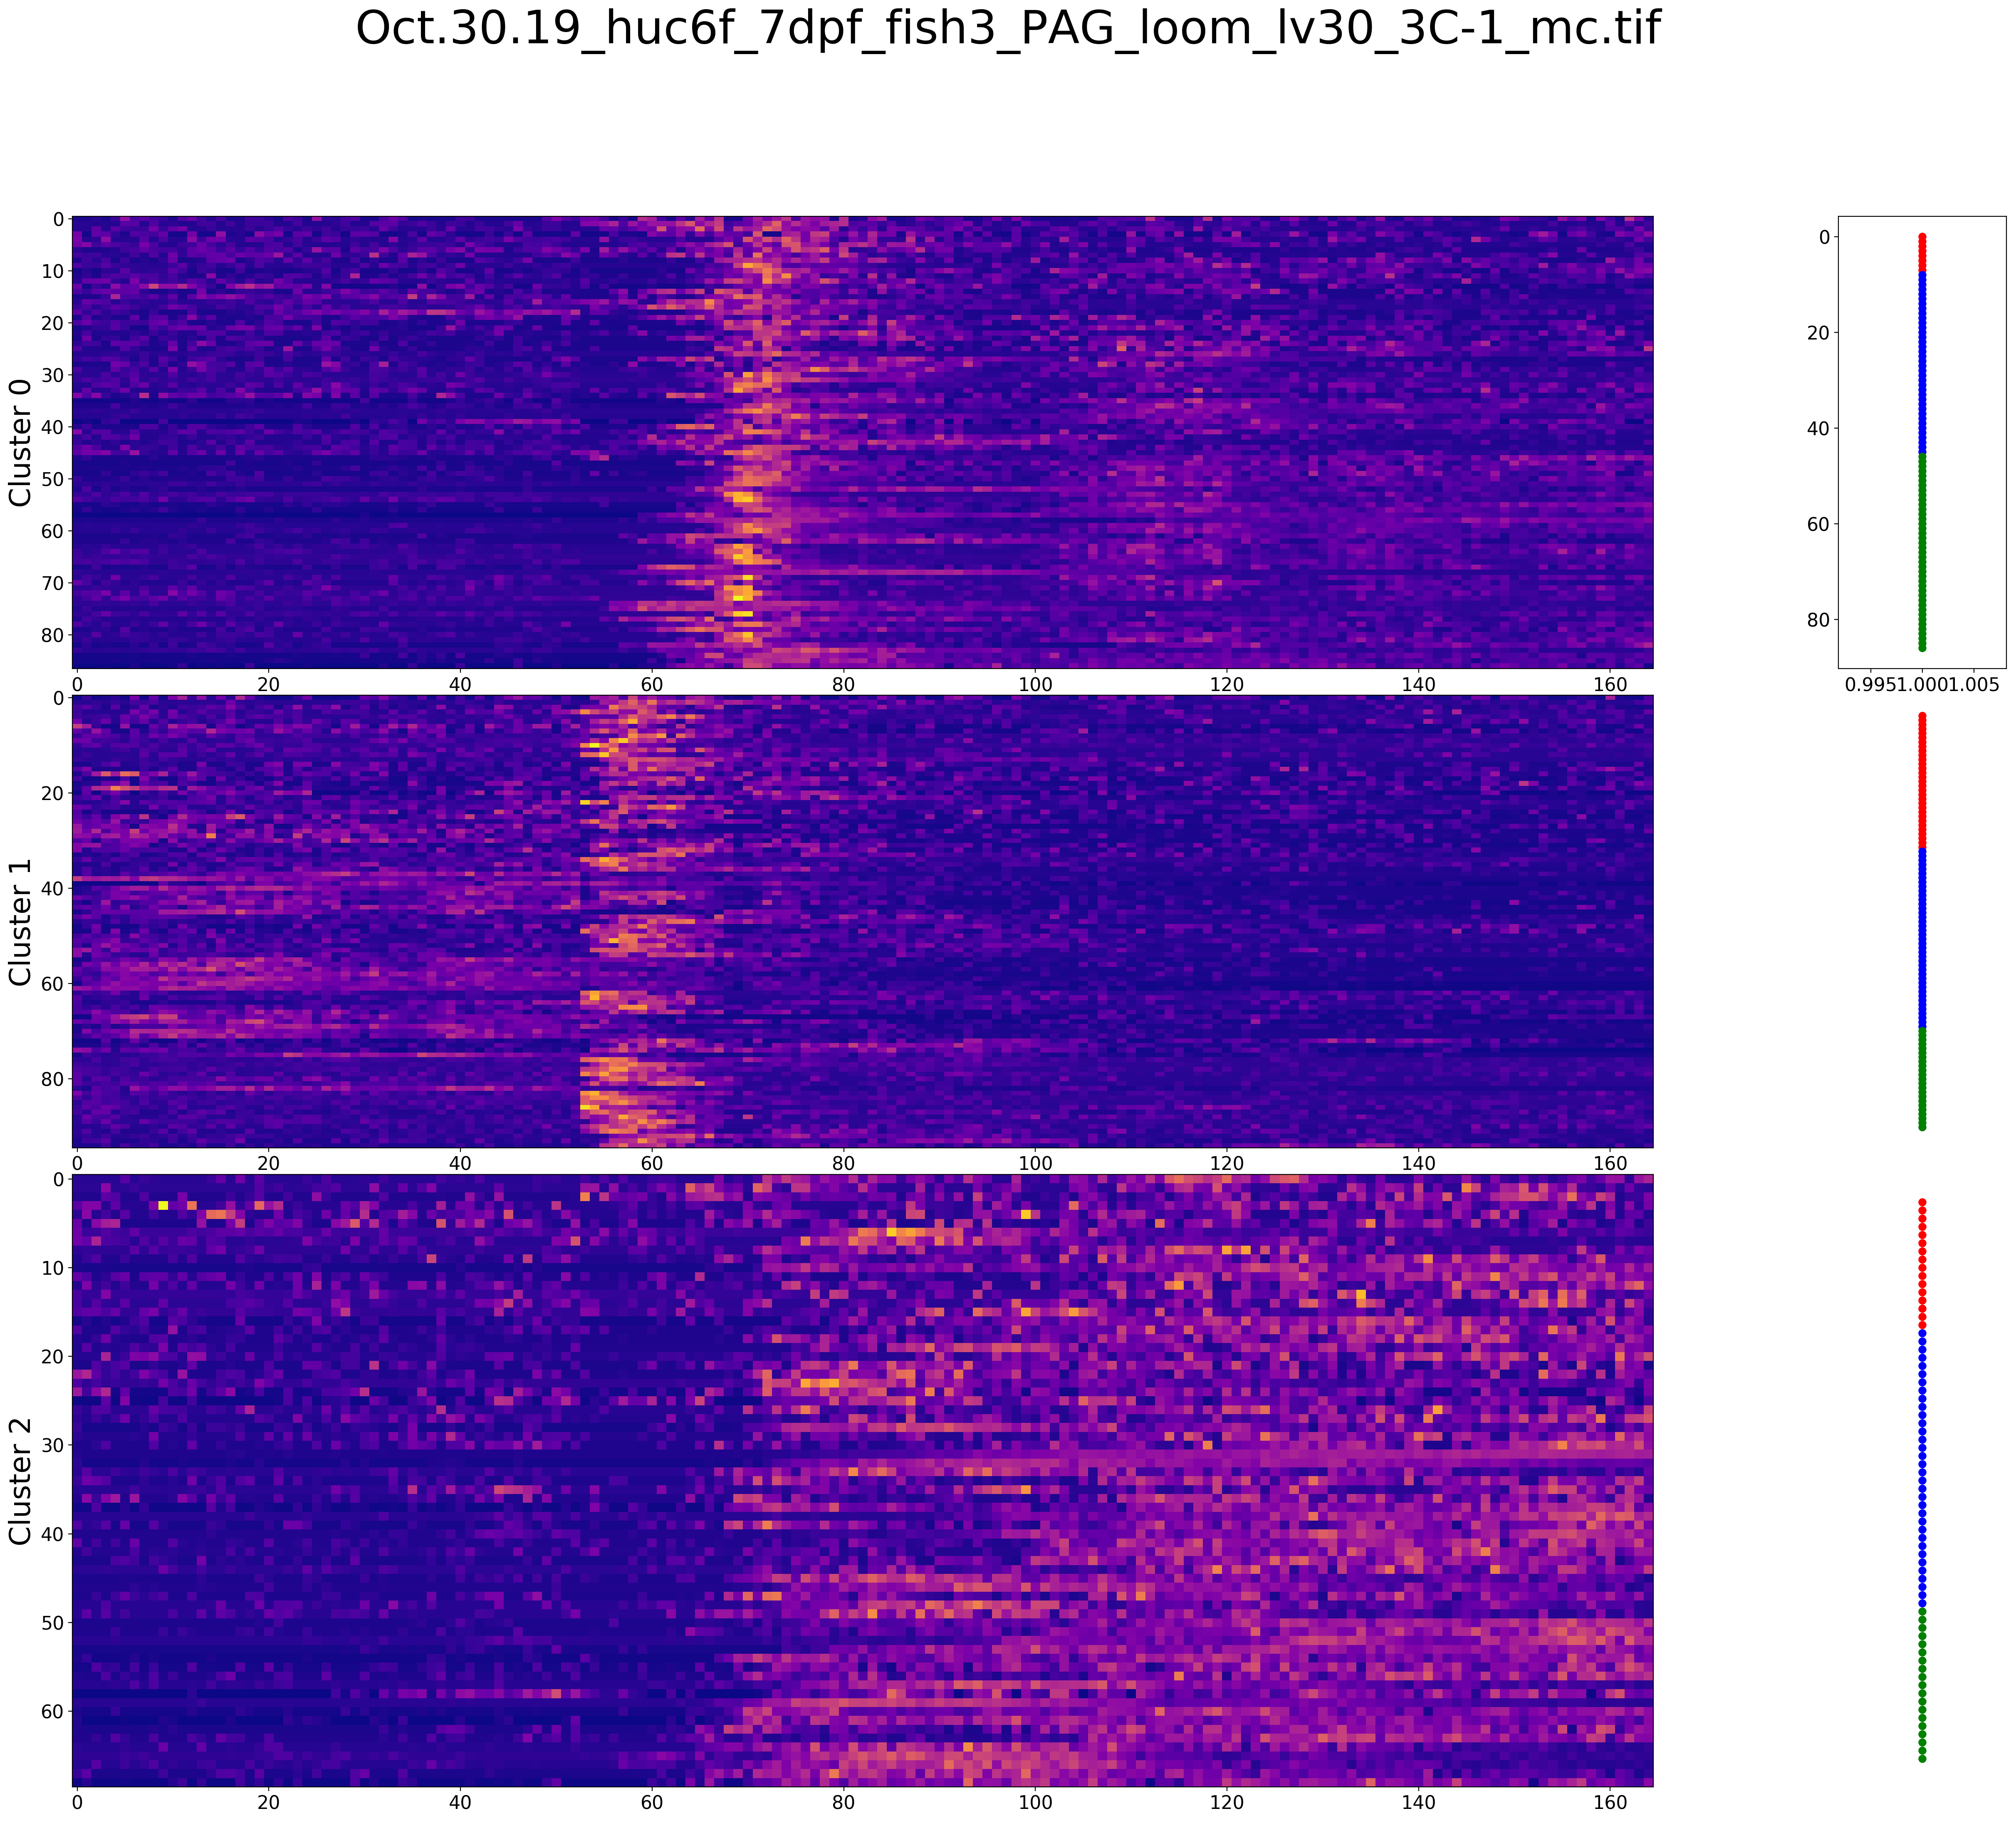

In [44]:
fig = plt.figure(figsize=(30, 25), dpi=200)

gs0 = gridspec.GridSpec(1,1, figure=fig)
# gs0 = gridspec.GridSpec(1,2, figure=fig)
# gs0 = gridspec.GridSpec(1,3, width_ratios=[3,2,1])

gs00 = gridspec.GridSpecFromSubplotSpec(10, 11, subplot_spec=gs0[0], wspace=0.05)
# gs01 = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=gs0[1])

# ax1 = fig.add_subplot(gs00[0:1,0])
# plt.imshow(label0, cmap = 'plasma', aspect = 'auto')
# ax2 = fig.add_subplot(gs00[1:4, 0])
# plt.imshow(label1, cmap = 'plasma', aspect = 'auto')
# ax3 = fig.add_subplot(gs00[4:,0])
# plt.imshow(label2, cmap = 'plasma', aspect = 'auto')
# plt.show


ax1 = fig.add_subplot(gs00[0:label0_prop,0:-2])
plt.ylabel('Cluster 0', fontsize=25)
plt.imshow(label0, cmap = 'plasma', aspect = 'auto')
axA = fig.add_subplot(gs00[0:label0_prop,-1])
plt.scatter(x=np.ones(len(color0)), y=(range(len(color0))), color = color0)
axA.invert_yaxis()
# plt.axis('off')
ax2 = fig.add_subplot(gs00[label0_prop:(label0_prop+label1_prop),0:-2])
plt.ylabel('Cluster 1', fontsize=25)
plt.imshow(label1, cmap = 'plasma', aspect = 'auto')
axB = fig.add_subplot(gs00[label0_prop:(label0_prop+label1_prop),-1])
plt.scatter(x=np.ones(len(color1)), y=(range(len(color1))), color = color1)
plt.axis('off')
axB.invert_yaxis()
ax3 = fig.add_subplot(gs00[(label0_prop+label1_prop):,0:-2])
plt.ylabel('Cluster 2', fontsize=25)
plt.imshow(label2, cmap = 'plasma', aspect = 'auto')
axC = fig.add_subplot(gs00[(label0_prop+label1_prop):,-1])
plt.scatter(x=np.ones(len(color2)), y=(range(len(color2))), color = color2)
plt.axis('off')
axC.invert_yaxis()
# ax4 = fig.add_subplot(gs00[(label0_prop+label1_prop+label2_prop):,0])
# plt.ylabel('Cluster 3')
# plt.imshow(label3, cmap = 'plasma', aspect = 'auto')
fig.suptitle("{}".format(video_name), fontsize=40)
plt.show
plt.savefig("40invertedN3SortedHeatMap.png")
